In [1]:
from collections import Counter, defaultdict
from itertools import combinations, chain, product
from matplotlib import pyplot as plt
import microhapdb
import networkx as nx
import sys
import time

In [2]:
markers = microhapdb.Marker.objectify(microhapdb.markers)
markers = [m for m in markers if "LV" not in m.name]

In [3]:
def build_graphs(markers):
    graphs = defaultdict(nx.Graph)
    chroms = sorted(set([m.chrom for m in markers]))
    for chrom in chroms:
        cmarkers = [m for m in markers if m.chrom == chrom]
        graphs[chrom].add_nodes_from(cmarkers)
        for mh1, mh2 in combinations(cmarkers, 2):
            if abs(mh1.start - mh2.start) >= 10e6:
                graphs[chrom].add_edge(mh1, mh2)
    return graphs

In [4]:
def build_light_graphs(markers):
    graphs = defaultdict(nx.Graph)
    chroms = sorted(set([m.chrom for m in markers]))
    for chrom in chroms:
        cmarkers = [m for m in markers if m.chrom == chrom]
        short = [m for m in cmarkers if len(m) < 100]
        medium = [m for m in cmarkers if 100 <= len(m) < 200]
        long = [m for m in cmarkers if 200 <= len(m) < 300]
        for marker_set in (short, medium, long):
            marker_set = sorted(marker_set, key=lambda m: m.data.Ae, reverse=True)
            marker_set = marker_set[:10]
            graphs[chrom].add_nodes_from(marker_set)
        for mh1, mh2 in combinations(graphs[chrom].nodes, 2):
            if abs(mh1.start - mh2.start) >= 10e6:
                graphs[chrom].add_edge(mh1, mh2)
    return graphs

In [5]:
graphs = build_light_graphs(markers)

In [6]:
for chrom, graph in graphs.items():
    print(f"{chrom:>5s}: nodes={graph.number_of_nodes():<3d} edges={graph.number_of_edges()}")

 chr1: nodes=30  edges=359
chr10: nodes=30  edges=342
chr11: nodes=30  edges=314
chr12: nodes=30  edges=374
chr13: nodes=30  edges=330
chr14: nodes=30  edges=290
chr15: nodes=30  edges=324
chr16: nodes=30  edges=262
chr17: nodes=30  edges=310
chr18: nodes=30  edges=312
chr19: nodes=30  edges=306
 chr2: nodes=30  edges=368
chr20: nodes=30  edges=316
chr21: nodes=30  edges=218
chr22: nodes=30  edges=253
 chr3: nodes=30  edges=366
 chr4: nodes=30  edges=380
 chr5: nodes=30  edges=372
 chr6: nodes=30  edges=389
 chr7: nodes=30  edges=352
 chr8: nodes=30  edges=366
 chr9: nodes=30  edges=333
 chrX: nodes=10  edges=40


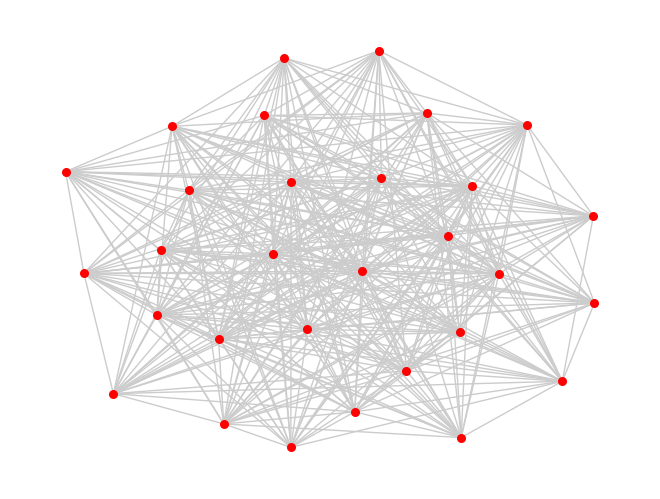

In [7]:
layout = nx.spring_layout(graphs["chr1"], seed=192837, k=3)
nx.draw(graphs["chr1"], pos=layout, node_size=30, node_color="red", edge_color="#cccccc")

In [8]:
def find_seed_nodes(cgraph):
    short = [mh for mh in cgraph.nodes if len(mh) < 100]
    medium = [mh for mh in cgraph.nodes if 100 <= len(mh) < 200]
    long = [mh for mh in cgraph.nodes if 200 <= len(mh) < 300]
    short = sorted(short, key=lambda mh: mh.data.Ae, reverse=True)
    medium = sorted(medium, key=lambda mh: mh.data.Ae, reverse=True)
    long = sorted(long, key=lambda mh: mh.data.Ae, reverse=True)
    if len(long) == 0 or len(medium) == 0 or len(short) == 0:
        return
    candidate_seed = (short[0], medium[0], long[0])
    for n, (mh_x, mh_y, mh_z) in enumerate(product(long[:4], medium[:4], short[:4])):
        for mh_i, mh_j in combinations((mh_x, mh_y, mh_z), 2):
            if abs(mh_i.start - mh_j.start) < 10e6:
                break
        else:
            print(f"{mh_x.chrom}: found seed on iteration {n}")
            return mh_x, mh_y, mh_z 
    raise ValueError(mh_x.chrom)

In [9]:
chrom_seeds = dict()
for chrom, cgraph in graphs.items():
    seeds = find_seed_nodes(cgraph)
    #chrom_seeds[chrom] = seeds
    chrom_seeds[chrom] = None

chr1: found seed on iteration 1
chr10: found seed on iteration 6
chr11: found seed on iteration 1
chr12: found seed on iteration 1
chr13: found seed on iteration 5
chr14: found seed on iteration 6
chr15: found seed on iteration 2
chr16: found seed on iteration 5
chr17: found seed on iteration 13
chr18: found seed on iteration 0
chr19: found seed on iteration 5
chr2: found seed on iteration 0
chr20: found seed on iteration 0
chr21: found seed on iteration 22
chr22: found seed on iteration 17
chr3: found seed on iteration 0
chr4: found seed on iteration 1
chr5: found seed on iteration 0
chr6: found seed on iteration 0
chr7: found seed on iteration 0
chr8: found seed on iteration 0
chr9: found seed on iteration 0


In [10]:
for chrom, seed in chrom_seeds.items():
    if seed is None:
        print(chrom, None)
    else:
        print(chrom, *[mh.name for mh in seed])

chr1 None
chr10 None
chr11 None
chr12 None
chr13 None
chr14 None
chr15 None
chr16 None
chr17 None
chr18 None
chr19 None
chr2 None
chr20 None
chr21 None
chr22 None
chr3 None
chr4 None
chr5 None
chr6 None
chr7 None
chr8 None
chr9 None
chrX None


In [11]:
cliques_by_chrom = dict()
clique_distr_by_chrom = dict()
for chrom, graph in sorted(graphs.items(), key=lambda cg: cg[1].number_of_edges()):
    seed = chrom_seeds[chrom]
    if seed is not None:
        seed = list(seed)
    start = time.time()
    cliques = list(nx.find_cliques(graph, nodes=seed))
    cliques_by_chrom[chrom] = cliques
    clique_distr_by_chrom[chrom] = Counter([len(c) for c in cliques])
    elapsed = time.time() - start
    print(f"{chrom} done! ({elapsed:.4f} seconds elapsed)", file=sys.stderr)

chrX done! (0.0002 seconds elapsed)
chr21 done! (0.0005 seconds elapsed)
chr22 done! (0.0007 seconds elapsed)
chr16 done! (0.0006 seconds elapsed)
chr14 done! (0.0009 seconds elapsed)
chr19 done! (0.0018 seconds elapsed)
chr17 done! (0.0011 seconds elapsed)
chr18 done! (0.0041 seconds elapsed)
chr11 done! (0.0022 seconds elapsed)
chr20 done! (0.0034 seconds elapsed)
chr15 done! (0.0027 seconds elapsed)
chr13 done! (0.0020 seconds elapsed)
chr9 done! (0.0029 seconds elapsed)
chr10 done! (0.0055 seconds elapsed)
chr7 done! (0.0036 seconds elapsed)
chr1 done! (0.0029 seconds elapsed)
chr3 done! (0.0091 seconds elapsed)
chr8 done! (0.0054 seconds elapsed)
chr2 done! (0.0058 seconds elapsed)
chr5 done! (0.0092 seconds elapsed)
chr12 done! (0.0156 seconds elapsed)
chr4 done! (0.0658 seconds elapsed)
chr6 done! (0.0268 seconds elapsed)


In [12]:
for chrom, dist in sorted(clique_distr_by_chrom.items()):
    print(f"{chrom:6s} ", end="")
    print(*dist.most_common())

chr1   (8, 918) (9, 648) (7, 324)
chr10  (8, 2304) (7, 624) (6, 36)
chr11  (5, 1652)
chr12  (8, 5184) (9, 1728) (7, 1536)
chr13  (6, 840) (5, 480) (4, 30)
chr14  (5, 462) (6, 70) (4, 6)
chr15  (6, 902) (5, 364) (7, 96) (4, 18)
chr16  (4, 378) (5, 54)
chr17  (5, 441) (6, 218) (4, 24) (7, 21)
chr18  (5, 1524) (6, 138) (4, 54)
chr19  (4, 1173) (5, 146) (3, 40)
chr2   (11, 1080) (10, 1080)
chr20  (4, 1433) (5, 340) (3, 21)
chr21  (3, 213) (2, 63)
chr22  (3, 436) (2, 24)
chr3   (8, 3456) (7, 1728)
chr4   (8, 10560)
chr5   (9, 5184)
chr6   (9, 6336) (10, 6336) (8, 1584)
chr7   (8, 804) (9, 336) (7, 144) (10, 36)
chr8   (9, 3456)
chr9   (6, 720) (5, 450) (7, 216)
chrX   (6, 8) (5, 8)


In [13]:
def has_short_medium_long(clique, mincount=1):
    short_count, medium_count, long_count = 0, 0, 0
    for marker in clique:
        mlen = len(marker)
        if mlen < 100:
            short_count += 1
        elif 100 <= mlen < 200:
            medium_count += 1
        elif 200 <= mlen < 300:
            long_count += 1
        if short_count >= mincount and medium_count >= mincount and long_count >= mincount:
            return True
    return False

In [15]:
helpful_cliques_2 = defaultdict(list)
helpful_cliques_1 = defaultdict(list)
for chrom, cliques in cliques_by_chrom.items():
    for clique in cliques:
        if has_short_medium_long(clique, mincount=2):
            helpful_cliques_2[chrom].append(clique)
    if len(helpful_cliques_2[chrom]) == 0:
        for clique in cliques:
            if has_short_medium_long(clique, mincount=1):
                helpful_cliques_1[chrom].append(clique)
    len2 = len(helpful_cliques_2[chrom])
    len1 = len(helpful_cliques_1[chrom])
    print(f"{chrom:6s} {len2:5} {len1:5}")

chrX       0     0
chr21      0    58
chr22      0   107
chr16      0   234
chr14     18     0
chr19      0   651
chr17     41     0
chr18     26     0
chr11      0   956
chr20      0   959
chr15    150     0
chr13    162     0
chr9     159     0
chr10   1515     0
chr7     652     0
chr1    1124     0
chr3    2720     0
chr8    1884     0
chr2    1958     0
chr5    4000     0
chr12   4744     0
chr4    5705     0
chr6   11528     0


In [16]:
def clique_avg_ae(clique):
    return sum(marker.data.Ae for marker in clique) / len(clique)

In [21]:
def clique_repr(clique, n):
    short = [mh for mh in clique if len(mh) < 100]
    medium = [mh for mh in clique if 100 <= len(mh) < 200]
    long = [mh for mh in clique if 200 <= len(mh) < 300]
    short = sorted(short, key=lambda mh: mh.data.Ae, reverse=True)
    medium = sorted(medium, key=lambda mh: mh.data.Ae, reverse=True)
    long = sorted(long, key=lambda mh: mh.data.Ae, reverse=True)
    return [*short[:n], *medium[:n], *long[:n]]

In [29]:
keepers = dict()
for chrom in cliques_by_chrom:
    if len(helpful_cliques_2[chrom]) == 0 and len(helpful_cliques_1[chrom]) == 0:
        continue
    if len(helpful_cliques_2[chrom]) > 0:
        cliques = helpful_cliques_2[chrom]
        n = 2
    else:
        cliques = helpful_cliques_1[chrom]
        n = 1
    best_avg_ae = 0.0
    best_clique = None
    for clique in cliques:
        clique = clique_repr(clique, n=n)
        avg_ae = clique_avg_ae(clique)
        if avg_ae > best_avg_ae:
            best_avg_ae = avg_ae
            best_clique = clique
    keepers[chrom] = best_clique

In [30]:
for chrom, clique in keepers.items():
    print(chrom, *[mh.name for mh in clique])

chr21 mh21KK-324.v4 mh21FHL-002.v1 mh21SCUZJ-0002749
chr22 mh22LS-22qB mh22WL-005.v1 mh22SCUZJ-0043764
chr16 mh16WL-040.v1 mh16WL-012.v1 mh16KK-259.v3
chr14 mh14WL-028.v2 mh14LW-35 mh14SCUZJ-0040957.v1 mh14SCUZJ-0096560 mh14SHY-003.v3 mh14WL-030.v2
chr19 mh19ZHA-006 mh19USC-19qA.v2 mh19SCUZJ-0249059.v1
chr17 mh17USC-17qB mh17CP-005 mh17KK-278.v2 mh17WL-004.v1 mh17WL-022.v1 mh17SCUZJ-0017214.v1
chr18 mh18LW-47 mh18WL-018 mh18SCUZJ-0246384 mh18SHY-001 mh18SCUZJ-0106007 mh18SCUZJ-0076547
chr11 mh11PK-63643.v1 mh11KK-183.v3 mh11SCUZJ-0402779
chr20 mh20SCUZJ-0148996 mh20WL-023.v1 mh20SCUZJ-0014987
chr15 mh15USC-15qA mh15LW-39 mh15SCUZJ-0082880 mh15WL-001.v1 mh15SCUZJ-0267777 mh15SCUZJ-0204760.v1
chr13 mh13USC-13qD mh13KK-225.v2 mh13USC-13qA.v2 mh13KK-218.v4 mh13WL-001.v2 mh13SCUZJ-0098743
chr9 mh09USC-9qC mh09USC-9qA mh09SCUZJ-0076471 mh09WL-034 mh09SHY-001.v3 mh09KK-153.v3
chr10 mh10SHY-002.v2 mh10SCUZJ-0204710.v2 mh10WL-012.v1 mh10WL-001.v1 mh10SCUZJ-0255190 mh10SCUZJ-0149820
chr7 mh07WL-

In [31]:
sum([len(clique) for clique in keepers.values()])

114

In [33]:
panel = list()
for clique in keepers.values():
    panel.extend(clique)
panel_short = [mh for mh in panel if len(mh) < 100]
panel_medium = [mh for mh in panel if 100 <= len(mh) < 200]
panel_long = [mh for mh in panel if 200 <= len(mh) < 300]
print(len(panel_short), len(panel_medium), len(panel_long))

38 38 38


In [35]:
print(*[mh.name for mh in panel])

mh21KK-324.v4 mh21FHL-002.v1 mh21SCUZJ-0002749 mh22LS-22qB mh22WL-005.v1 mh22SCUZJ-0043764 mh16WL-040.v1 mh16WL-012.v1 mh16KK-259.v3 mh14WL-028.v2 mh14LW-35 mh14SCUZJ-0040957.v1 mh14SCUZJ-0096560 mh14SHY-003.v3 mh14WL-030.v2 mh19ZHA-006 mh19USC-19qA.v2 mh19SCUZJ-0249059.v1 mh17USC-17qB mh17CP-005 mh17KK-278.v2 mh17WL-004.v1 mh17WL-022.v1 mh17SCUZJ-0017214.v1 mh18LW-47 mh18WL-018 mh18SCUZJ-0246384 mh18SHY-001 mh18SCUZJ-0106007 mh18SCUZJ-0076547 mh11PK-63643.v1 mh11KK-183.v3 mh11SCUZJ-0402779 mh20SCUZJ-0148996 mh20WL-023.v1 mh20SCUZJ-0014987 mh15USC-15qA mh15LW-39 mh15SCUZJ-0082880 mh15WL-001.v1 mh15SCUZJ-0267777 mh15SCUZJ-0204760.v1 mh13USC-13qD mh13KK-225.v2 mh13USC-13qA.v2 mh13KK-218.v4 mh13WL-001.v2 mh13SCUZJ-0098743 mh09USC-9qC mh09USC-9qA mh09SCUZJ-0076471 mh09WL-034 mh09SHY-001.v3 mh09KK-153.v3 mh10SHY-002.v2 mh10SCUZJ-0204710.v2 mh10WL-012.v1 mh10WL-001.v1 mh10SCUZJ-0255190 mh10SCUZJ-0149820 mh07WL-072 mh07SCUZJ-0350377 mh07KK-009.v3 mh07SCUZJ-0395598 mh07SCUZJ-0502291.v2 mh07WL-

In [41]:
source_counts = Counter()
for mh in panel:
    for source in mh.data.Source.split(";"):
        source_counts[source] += 1
print(*source_counts.most_common(), sep="\n")

('Zhu2023', 44)
('Yu2022G1', 23)
('Yu2022G3', 18)
('Yu2022G2', 17)
('Yu2022G4', 11)
('Zhang2023', 8)
('delaPuente2020', 7)
('Pakstis2021', 4)
('Fan2022', 3)
('Wu2021', 3)
('NimaGen2023', 3)
('Gandotra2020', 3)
('Staadig2021', 2)
('Du2023', 1)
('Sun2020', 1)
('Kidd2018', 1)
('vanderGaag2018', 1)


In [3]:
def clique_distr_per_chromosome(cmarkers):
    cgraph = nx.Graph()
    cgraph.add_nodes_from(cmarkers)
    for mh1, mh2 in combinations(cmarkers, 2):
        if abs(mh1.start - mh2.start) >= 10e6:
            cgraph.add_edge(mh1, mh2)
    cliques = list(nx.find_cliques(cgraph))
    clique_size_distr = Counter([len(c) for c in cliques])
    return cliques, clique_size_distr

In [ ]:
chroms = sorted(set([m.chrom for m in markers]))
cliques_by_chrom = dict()
clique_distr_by_chrom = dict()
for chrom in chroms:
    cmarkers = [m for m in markers if m.chrom == chrom]
    cliques, clique_size_distr = clique_distr_per_chromosome(cmarkers)
    cliques_by_chrom[chrom] = cliques
    clique_distr_by_chrom[chrom] = clique_size_dist
    print(f"{chrom} done!")

In [3]:
short = [m for m in markers if len(m) < 100]
medium = [m for m in markers if 100 <= len(m) < 200]
long = [m for m in markers if 200 <= len(m) < 300]
print(f"short N={len(short)} maxAe={max([m.data.Ae for m in short])}")
print(f"medium N={len(medium)} maxAe={max([m.data.Ae for m in medium])}")
print(f"long N={len(long)} maxAe={max([m.data.Ae for m in long])}")

short N=675 maxAe=10.818
medium N=1139 maxAe=16.593
long N=768 maxAe=72.533


In [27]:
graph = nx.Graph()
cmarkers = [m for m in markers if m.chrom == "chr19"]
graph.add_nodes_from(cmarkers)
for mh1, mh2 in combinations(cmarkers, 2):
    if abs(mh1.start - mh2.start) >= 10e6:
        graph.add_edge(mh1, mh2)

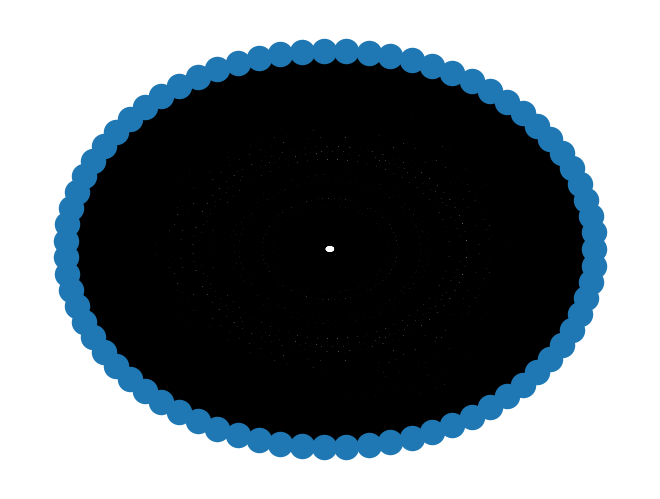

In [34]:
nx.draw_circular(graph)

In [29]:
gprime = max(nx.connected_components(graph), key=len)
print(len(graph), len(gprime))

75 75


In [31]:
cliques = list(nx.enumerate_all_cliques(graph))
len(cliques)

154508

In [79]:
max([len(c) for c in cliques])

6

In [80]:
max_cliques = [c for c in cliques if len(c) >= 5]
len(max_cliques)

48145

In [82]:
max_cliques_all_lengths = [c for c in max_cliques if has_short_medium_long(c)]
len(max_cliques_all_lengths)

25415

In [84]:
max_cliques_all_lengths_sorted = sorted(max_cliques_all_lengths, key=lambda c: clique_avg_ae(c), reverse=True)

In [85]:
[m.name for m in max_cliques_all_lengths_sorted[0]], clique_avg_ae(max_cliques_all_lengths_sorted[0])

(['mh19SCUZJ-0028962',
  'mh19SCUZJ-0091391',
  'mh19USC-19qA.v2',
  'mh19WL-018',
  'mh19SCUZJ-0249059.v1'],
 9.2618)

In [86]:
[m.name for m in max_cliques_all_lengths_sorted[1]], clique_avg_ae(max_cliques_all_lengths_sorted[1])

(['mh19SCUZJ-0028962',
  'mh19USC-19pB',
  'mh19SCUZJ-0121709',
  'mh19SCUZJ-0164190',
  'mh19SCUZJ-0249059.v1'],
 9.099599999999999)

In [87]:
[m.name for m in max_cliques_all_lengths_sorted[2]], clique_avg_ae(max_cliques_all_lengths_sorted[2])

(['mh19SCUZJ-0028962',
  'mh19USC-19pB',
  'mh19ZHA-007',
  'mh19SCUZJ-0164190',
  'mh19SCUZJ-0249059.v1'],
 9.0414)

In [ ]:
# generate cliques of different lengths for each chromosome; combine, rank, filter, and see which panel of 120 has the best avg Ae